Here we will classify for more than two images. The steps involved are almost the same as before.

In [1]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
BASE_DIR = './rps'

rock_dir = os.path.join(BASE_DIR, 'train/rock')
paper_dir = os.path.join(BASE_DIR, 'train/paper')
scissors_dir = os.path.join(BASE_DIR, 'train/scissors')

print('Total number of training rock images : ', len(os.listdir(rock_dir)))
print('Total number of training paper images : ', len(os.listdir(paper_dir)))
print('Total number of training scissors images : ', len(os.listdir(scissors_dir)))

Total number of training rock images :  329
Total number of training paper images :  362
Total number of training scissors images :  329


In [3]:
rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

In [4]:
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'val')

training_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DIR,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)


SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = training_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
val_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

Found 1020 files belonging to 3 classes.
Found 804 files belonging to 3 classes.


In [5]:
data_augmentation_model = tf.keras.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
])

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150,150,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),  # Change to 128 as per suggestion in course
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),  # Change to 64 as per course suggestion
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)       

I have changed for few number of neurons due to computation limitations

In [7]:
model_with_aug = tf.keras.models.Sequential([
    data_augmentation_model,
    model
])

model_with_aug.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
class EarlyStopCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.80:
            self.model.stop_training=True
            print('Model reached 80% accuracy')

In [9]:
history = model_with_aug.fit(
    train_dataset_final, epochs = 25, validation_data= val_dataset_final, verbose=2, callbacks=[EarlyStopCallBack()])

Epoch 1/25
32/32 - 60s - loss: 1.1133 - accuracy: 0.3373 - val_loss: 1.1227 - val_accuracy: 0.3321 - 60s/epoch - 2s/step
Epoch 2/25
32/32 - 33s - loss: 1.1027 - accuracy: 0.3480 - val_loss: 1.0984 - val_accuracy: 0.3333 - 33s/epoch - 1s/step
Epoch 3/25
32/32 - 26s - loss: 1.0996 - accuracy: 0.3490 - val_loss: 1.1147 - val_accuracy: 0.3308 - 26s/epoch - 805ms/step
Epoch 4/25
32/32 - 29s - loss: 1.1016 - accuracy: 0.3422 - val_loss: 1.0886 - val_accuracy: 0.4378 - 29s/epoch - 899ms/step
Epoch 5/25
32/32 - 27s - loss: 1.0990 - accuracy: 0.3500 - val_loss: 1.0903 - val_accuracy: 0.3607 - 27s/epoch - 844ms/step
Epoch 6/25
32/32 - 26s - loss: 1.0921 - accuracy: 0.3882 - val_loss: 1.0840 - val_accuracy: 0.3532 - 26s/epoch - 819ms/step
Epoch 7/25
32/32 - 26s - loss: 1.0874 - accuracy: 0.3794 - val_loss: 1.0705 - val_accuracy: 0.4005 - 26s/epoch - 800ms/step
Epoch 8/25
32/32 - 25s - loss: 1.0731 - accuracy: 0.4039 - val_loss: 1.0384 - val_accuracy: 0.4614 - 25s/epoch - 792ms/step
Epoch 9/25
32/

In [10]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

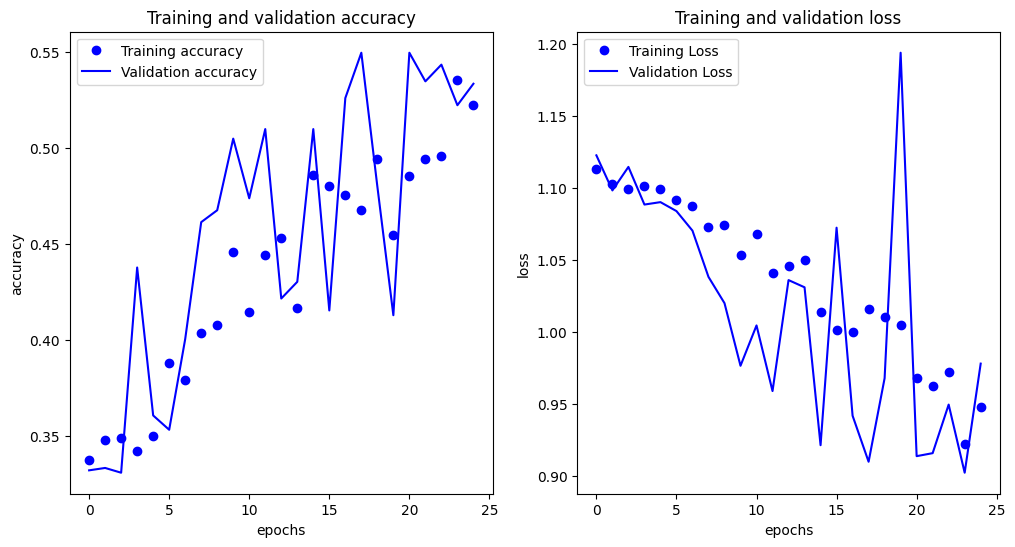

In [11]:
plot_loss_acc(history)

In [16]:
TESTING_DIR = os.path.join(BASE_DIR, 'test')

testing_dataset = tf.keras.utils.image_dataset_from_directory(
    TESTING_DIR,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

test_loss, test_accuracy = model_with_aug.evaluate(testing_dataset, verbose=False)

Found 540 files belonging to 3 classes.


In [17]:
test_loss, test_accuracy

(1.0608102083206177, 0.4018518626689911)

In [20]:
prediction = model.predict(val_dataset_final, verbose=False)
labels = np.concatenate([label_batch.numpy() for _, label_batch in val_dataset_final])
labels = [int(lab) for label in labels for lab in label]
prediction = [1 if x[0] > 0.5 else 0 for x in prediction]

match = sum(a == b for a, b in zip(prediction, labels))
non_match = len(labels) - match

match, non_match

(534, 1878)

Increase the neuron count and number of epochs to get higher accuracy